In [7]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R

#### Single Segment CR

1. Task space $P=[x, y,z]^T$ to Configuration space $\psi=[\theta, \phi]^T$.

    We know that
    $$
    \begin{bmatrix}
    x \\ y \\ z \\ \end{bmatrix} = \frac{L}{\theta}
    \begin{bmatrix}
    (1-cos(\theta))cos(\phi) \\ (1-cos(\theta))sin(\phi) \\ sin(\theta)\\
    \end{bmatrix}
    $$


In [10]:
config = np.array([np.pi /2, 0])
L = 300
[x, y, z] = single_segment_cal_position_from_config(L, config[0], config[1])
print([x, y, z])

config = np.array([np.pi /2, 0.1])
[x, y, z] = single_segment_cal_position_from_config(L, config[0], config[1])
print([x, y, z])


[190.98593171027437, 0.0, 190.9859317102744]
[190.03179756122756, 19.06677809411449, 190.9859317102744]


In [9]:
def single_segment_cal_position_from_config(L, theta, phi):

    """Calculate forward kinematics P = [x, y, z]"""
    eps = 1e-10
    if abs(theta) < eps:
        theta = eps
        
    x = (L/theta) * (1-np.cos(theta)) * np.cos(phi)
    y = (L/theta) * (1-np.cos(theta)) * np.sin(phi)
    z = (L/theta) * np.sin(theta)
    
    return np.array([x, y, z])

In [11]:
config = np.array([np.pi /2, 0])
L = 300
[x, y, z] = single_segment_cal_position_from_config(L, config[0], config[1])
print([x, y, z])

config = np.array([np.pi /2, 0.1])
[x, y, z] = single_segment_cal_position_from_config(L, config[0], config[1])
print([x, y, z])


[190.98593171027437, 0.0, 190.9859317102744]
[190.03179756122756, 19.06677809411449, 190.9859317102744]


##### Using Jacobian method, which $P' = J\psi'$

$$
\begin{bmatrix}
x \\ y \\ z \\
\end{bmatrix}' = \begin{bmatrix}
\frac{\partial x}{\partial \theta} & \frac{\partial x}{\partial \phi} \\
\frac{\partial y}{\partial \theta} & \frac{\partial y}{\partial \phi} \\
\frac{\partial z}{\partial \theta} & \frac{\partial z}{\partial \phi} \\
\end{bmatrix} \begin{bmatrix}
\theta \\ \phi \\
\end{bmatrix}'
$$

with 

\begin{align*}
\frac{\partial x}{\partial \theta} &= \cos(\phi) \left( -\frac{L}{\theta^2} (1 - \cos(\theta)) + \frac{L}{\theta} \sin(\theta) \right) \\
\frac{\partial x}{\partial \phi} &= \frac{L}{\theta} (1 - \cos(\theta)) (-\sin(\phi)) \\
\frac{\partial y}{\partial \theta} &= \sin(\phi) \left( -\frac{L}{\theta^2} (1 - \cos(\theta)) + \frac{L}{\theta} \sin(\theta) \right) \\
\frac{\partial y}{\partial \phi} &= \frac{L}{\theta} (1 - \cos(\theta)) \cos(\phi) \\
\frac{\partial z}{\partial \theta} &= -\frac{L}{\theta^2} \sin(\theta) + \frac{L}{\theta} \cos(\theta) \\
\frac{\partial z}{\partial \phi} &= 0
\end{align*}

In [12]:
def single_segment_cal_jacobian(L, theta, phi):
    # Prevent division by zero
    eps = 1e-10
    if abs(theta) < eps:
        theta = eps

    # Common terms
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    
    # Jacobian matrix calculations
    J11 = cos_phi * (-L / theta**2 * (1 - cos_theta) + L / theta * sin_theta)
    J12 = -L / theta * (1 - cos_theta) * sin_phi  # Removed asterisk
    J21 = sin_phi * (-L / theta**2 * (1 - cos_theta) + L / theta * sin_theta)
    J22 = L / theta * (1 - cos_theta) * cos_phi   # Removed asterisk
    J31 = -L / theta**2 * sin_theta + L / theta * cos_theta
    J32 = 0

    # Create the Jacobian matrix
    J = np.array([[J11, J12], 
                [J21, J22], 
                [J31, J32]])
    
    return J

def forward_step(theta, phi, delta_psi, L=300):
    """Calculate ΔP given Δpsi"""
    J = single_segment_cal_jacobian(L, theta, phi)
    delta_P = J @ delta_psi
    return delta_P

def inverse_step(theta, phi, delta_P, L=300):
    """Calculate Δpsi given ΔP using pseudoinverse"""
    J = single_segment_cal_jacobian(theta, phi, L)
    # Calculate pseudoinverse
    J_pinv = np.linalg.pinv(J)
    delta_psi = J_pinv @ delta_P
    return delta_psi

In [13]:
# Constants
L = 300
psi_c = np.array([np.pi/2, 0])     # current configuration vector
theta = psi_c[0]
phi = psi_c[1]

# Jacobian matrix calculations
J11 = math.cos(phi) * (-L / theta**2 * (1 - math.cos(theta)) + L / theta * math.sin(theta))
J12 = -L / theta * (1 - math.cos(theta)) * math.sin(phi)  # Removed asterisk
J21 = math.sin(phi) * (-L / theta**2 * (1 - math.cos(theta)) + L / theta * math.sin(theta))
J22 = L / theta * (1 - math.cos(theta)) * math.cos(phi)   # Removed asterisk
J31 = -L / theta**2 * math.sin(theta) + L / theta * math.cos(theta)
J32 = 0

# Create the Jacobian matrix
J = np.array([[J11, J12], 
              [J21, J22], 
              [J31, J32]])
# Print the Jacobian matrix
print(J)

# given the tharget configuration vector psi_t
psi_t = np.array([np.pi/2 + 0.1, 0])

# calculate the error/step length
error = psi_t - psi_c
print("Error:")
print(error)

# Calculate the required joint velocities
# Using the pseudo-inverse of the Jacobian for redundancy resolution
# J_pseudo_inverse = np.linalg.pinv(J)
# velocity_input = J_pseudo_inverse @ error
position_output = J @ np.transpose(error)

# Print the required velocity input
print("Position Change Onput:")
print(position_output)

# Calculate current end-effector position based on psi_c
x_current = L / theta * (1 - math.cos(theta)) * math.cos(phi)
y_current = L / theta * (1 - math.cos(theta)) * math.sin(phi)
z_current = L / theta * math.sin(theta)

current_position = np.array([x_current, y_current, z_current])
print(current_position)

print("Final Position:")
print(position_output + current_position)

[[  69.40051134   -0.        ]
 [   0.          190.98593171]
 [-121.58542037    0.        ]]
Error:
[0.1 0. ]
Position Change Onput:
[  6.94005113   0.         -12.15854204]
[190.98593171   0.         190.98593171]
Final Position:
[197.92598284   0.         178.82738967]


##### Example of path following

Given a circular path, which the height (z) is equal to the center angle of $\theta$, and rotated with the $\phi = [0, 2\pi]$

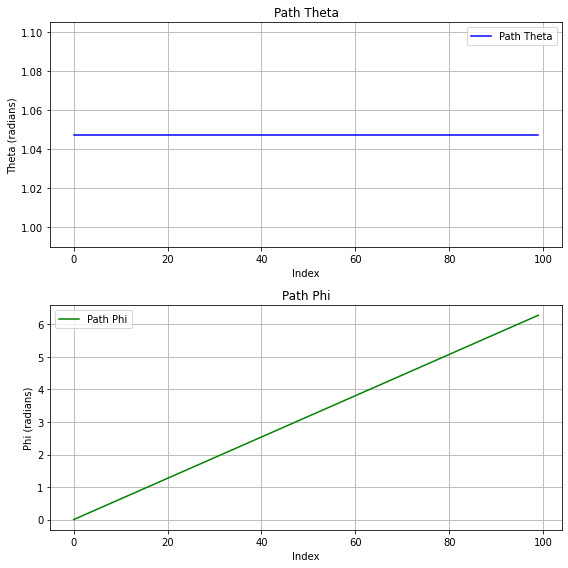

In [14]:
# generate the path
n = np.linspace(0, 100, 100)
path_theta = np.linspace(np.pi/3, np.pi /3, 100)
path_phi = np.linspace(0, 2*np.pi, 100)
L = 300

# Create a figure and axis for the plots
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot path_theta
axs[0].plot(path_theta, label='Path Theta', color='blue')
axs[0].set_title('Path Theta')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Theta (radians)')
axs[0].legend()
axs[0].grid(True)

# Plot path_phi
axs[1].plot(path_phi, label='Path Phi', color='green')
axs[1].set_title('Path Phi')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Phi (radians)')
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

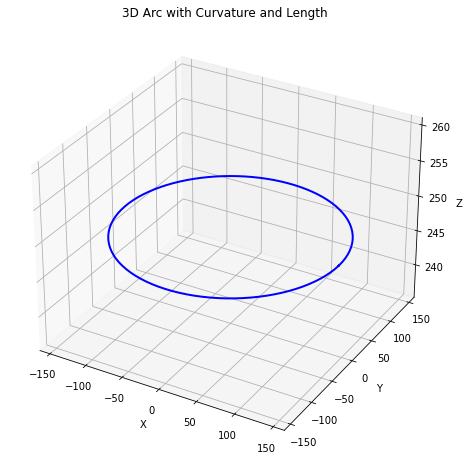

In [15]:
path_x = (L/path_theta) * (1-np.cos(path_theta)) * np.cos(path_phi)
path_y = (L/path_theta) * (1-np.cos(path_theta)) * np.sin(path_phi)
path_z = (L/path_theta) * np.sin(path_theta)

# print("Path X: ", path_x)


# Create the figure and 3D axis
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the arc in 3D
ax.plot(path_x, path_y, path_z, color='blue', linewidth=2)

# Set the x, y, and z limits
# ax.set_xlim(-15, 15)
# ax.set_ylim(-15, 15)
# ax.set_zlim(0, 35)

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Arc with Curvature and Length')

# Show the plot
plt.show()

In [16]:
# now test the jacobian method for the inverse transformation 
# of the task space to the configuration space
p_init = np.array([path_x[0], path_y[0], path_z[0]])
psi_init = np.array([path_theta[0], path_phi[0]])
max_iterations = 100
convergence_threshold = 1e-6

path_theta_output = np.zeros(100)
path_phi_output = np.zeros(100)

J = single_segment_cal_jacobian(300, psi_init[0], psi_init[1])
print(J)
J_inv = np.linalg.pinv(J)
print(J_inv)

current_theta = psi_init[0]
current_phi = psi_init[1]
path_theta_output[0] = psi_init[0]
path_phi_output[0] = psi_init[1]

for i in range (1, len(path_x)):
    # target position
    p_target = np.array([path_x[i], path_y[i], path_z[i]])
    print("p_target: ", p_target)
    p_current = single_segment_cal_position_from_config(300, current_theta, current_phi)
    
    # Iterative correction using Jacobian
    for iter in range(max_iterations):
        # Calculate position error
        pos_error = p_target - p_current
        
        if np.linalg.norm(pos_error) < convergence_threshold:
            break
            
        # Calculate Jacobian and its pseudoinverse
        J = single_segment_cal_jacobian(300, current_theta, current_phi)
        J_pinv = np.linalg.pinv(J)
        
        # Calculate delta psi
        delta_psi = J_pinv @ pos_error
        
        # Update current psi
        current_theta += delta_psi[0]
        current_phi += delta_psi[1]
        
        # Update current position
        p_current = single_segment_cal_position_from_config(300, current_theta, current_phi)
    
    # Store results
    path_theta_output[i] = current_theta
    path_phi_output[i] = current_phi
    
    
print(path_theta_output)

[[111.31440502  -0.        ]
 [  0.         143.23944878]
 [-93.67669245   0.        ]]
[[ 0.00525906  0.         -0.00442576]
 [ 0.          0.00698132  0.        ]]
p_target:  [142.95106143   9.08480729 248.09800294]
p_target:  [142.08706061  18.13303327 248.09800294]
p_target:  [140.65092534  27.10824392 248.09800294]
p_target:  [138.64843844  35.97429925 248.09800294]
p_target:  [136.08766321  44.69549876 248.09800294]
p_target:  [132.97891099  53.23672528 248.09800294]
p_target:  [129.33469964  61.5635863  248.09800294]
p_target:  [125.16970309  69.64255248 248.09800294]
p_target:  [120.50069233  77.44109268 248.09800294]
p_target:  [115.34646781  84.92780494 248.09800294]
p_target:  [109.72778378  92.0725429  248.09800294]
p_target:  [103.66726468  98.84653722 248.09800294]
p_target:  [ 97.18931411 105.22251143 248.09800294]
p_target:  [ 90.32001646 111.17479172 248.09800294]
p_target:  [ 83.08703199 116.67941036 248.09800294]
p_target:  [ 75.51948536 121.7142022  248.09800294]
p

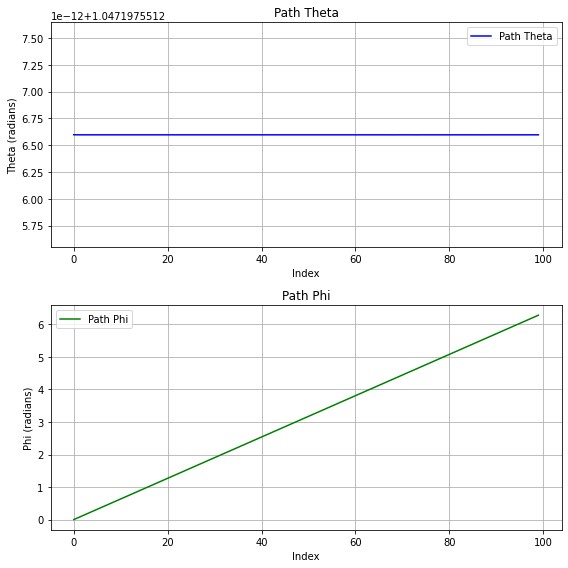

In [17]:
# Create a figure and axis for the plots
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot path_theta
axs[0].plot(path_theta_output, label='Path Theta', color='blue')
axs[0].set_title('Path Theta')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Theta (radians)')
axs[0].legend()
axs[0].grid(True)

# Plot path_phi
axs[1].plot(path_phi_output, label='Path Phi', color='green')
axs[1].set_title('Path Phi')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Phi (radians)')
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

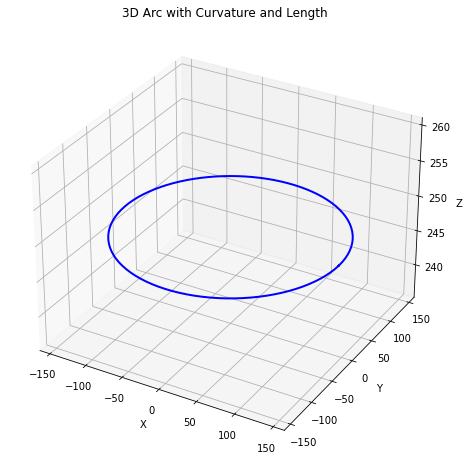

In [18]:
path_x_output = (L/path_theta_output) * (1-np.cos(path_theta_output)) * np.cos(path_phi_output)
path_y_output = (L/path_theta_output) * (1-np.cos(path_theta_output)) * np.sin(path_phi_output)
path_z_output = (L/path_theta_output) * np.sin(path_theta_output)

# print("Path X: ", path_x)


# Create the figure and 3D axis
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the arc in 3D
ax.plot(path_x_output, path_y_output, path_z_output, color='blue', linewidth=2)

# Set the x, y, and z limits
# ax.set_xlim(-15, 15)
# ax.set_ylim(-15, 15)
# ax.set_zlim(0, 35)

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Arc with Curvature and Length')

# Show the plot
plt.show()

2. Configuration Space $\psi=[\theta, \phi]^T$ to Actuation Space $q = [q_x, q_y]^T$.

    We know that:
    $$
    \begin{bmatrix} q_x \\ q_y \\ \end{bmatrix} = 
    \begin{bmatrix}
        -\theta r_t cos(\phi) \\ -\theta r_t sin(\phi) \\ \end{bmatrix}
    $$

    where the $r_t$ is the tendon offset from the backbone.

    Therefore, using Jacobian method, we have:

    $$
    \begin{bmatrix} q_x \\ q_y \\ \end{bmatrix}' = 

    \begin{bmatrix} 
    \frac{\partial q_x}{\partial \theta} & \frac{\partial q_x}{\partial \phi} \\ 
    \frac{\partial q_y}{\partial \theta} & \frac{\partial q_y}{\partial \phi} \\ \end{bmatrix}

    \begin{bmatrix} \theta \\ \phi \\ \end{bmatrix}' = 

    \begin{bmatrix} 
    -r_t cos(\phi) & \theta r_t sin(\phi) \\ 
    -r_t sin(\phi) & - \theta r_t cos(\phi) \\ \end{bmatrix} 

    \begin{bmatrix} \theta \\ \phi \\ \end{bmatrix}'
    $$


In [19]:
rt = 10.5

# Element-wise calculations using NumPy
qx = - path_theta_output * rt * np.cos(path_phi_output)
qy = - path_theta_output * rt * np.sin(path_phi_output)

# print("qx: ", qx)
# print("qy: ", qy)

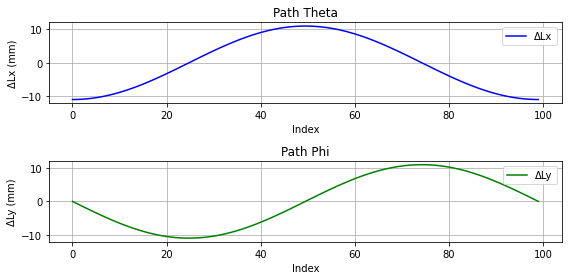

In [20]:
# Create a figure and axis for the plots
fig, axs = plt.subplots(2, 1, figsize=(8, 4))

# Plot path_theta
axs[0].plot(qx, label='ΔLx', color='blue')
axs[0].set_title('Path Theta')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('ΔLx (mm)')
axs[0].legend()
axs[0].grid(True)

# Plot path_phi
axs[1].plot(qy, label='ΔLy', color='green')
axs[1].set_title('Path Phi')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('ΔLy (mm)')
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

#### Dual Segment CR

1. Task space $P=[x, y, z, \alpha, \beta, \gamma]^T$ to Configuration space $\psi=[\theta, \phi]^T$.

    We know that
    $$
    \begin{bmatrix}
    x \\ y \\ z \\ \end{bmatrix} = \frac{L}{\theta}
    \begin{bmatrix}
    (1-cos(\theta))cos(\phi) \\ (1-cos(\theta))sin(\phi) \\ sin(\theta)\\
    \end{bmatrix}
    $$

  $$
  \mathbf{R_k^{k-1}} =
    \begin{bmatrix}
    \alpha \\ \beta \\ \gamma  \end{bmatrix} =  \mathbf{R_z(\phi_k)R_y(\theta_k)R_z(-\phi_k)}
  $$
  where

$$
R_z(\phi) = \begin{bmatrix}
    cos(\phi) & -sin(\phi) & 0 \\
    sin(\phi) & cos(\phi) & 0 \\
    0 & 0 & 1
\end{bmatrix},  R_y(\theta) = \begin{bmatrix}
    cos(\theta) & 0 & sin(\theta) \\
    0 & 1 & 0 \\
    -sin(\theta) & 0 & cos(\theta) \\
\end{bmatrix}
$$

We can construct the homogeneous transformation matrix $T_k^{k-1}$ as the form:
$$
T_k^{k-1} = \begin{bmatrix}
    \mathbf{R}^{k-1}_k & \mathbf{P}^{k-1}_k \\
    \mathbf{0} & 1
\end{bmatrix}
$$

$$
T_k^{k-1} = \begin{bmatrix}
    cos^2(\phi_k)cos(\theta_k)+sin^2(\phi_k) & cos(\phi_k)sin(\phi_k)(cos(\theta_k)-1) & cos(\phi_k)sin(\theta_k) & \frac{L_k}{\theta_k}(1-cos(\theta_k))cos(\phi) \\
    cos(\phi_k)sin(\phi_k)(cos(\theta_k)-1) & sin^2(\phi_k)cos(\theta_k)+cos^2(\phi_k) & sin(\phi_k)sin(\theta_k) & \frac{L_k}{\theta_k}(1-cos(\theta_k))sin(\phi) \\
    -cos(\phi_k)sin(\theta_k) & -sin(\phi_k)sin(\theta_k) & cos(\theta_k) & \frac{L_k}{\theta_k}sin(\theta_k)\\
    0 & 0 & 0 & 1 \\
\end{bmatrix}
$$



Therefore, we can have the overall representation of the dual-segment continuum robot:

$$
T = T_0^1T_1^2 = \begin{bmatrix}
    T_{11} & T_{12} & T_{13} & T_{14} \\
    T_{21} & T_{22} & T_{23} & T_{24} \\
    T_{31} & T_{32} & T_{33} & T_{34} \\
    T_{41} & T_{42} & T_{43} & T_{44} \\
\end{bmatrix}
$$
with
\begin{equation*}
    \begin{aligned}
        T_{11} & =
            \left(\sin^{2}{\left(\phi_{1} \right)} + \cos^{2}{\left(\phi_{1} \right)} \cos{\left(\theta_{1} \right)}\right) \left(\sin^{2}{\left(\phi_{2} \right)} + \cos^{2}{\left(\phi_{2} \right)} \cos{\left(\theta_{2} \right)}\right) \\
        & + 
        \left( \cos{\left(\theta_{1} \right)} - 1 \right) \left( \cos{\left(\theta_{2} \right)} - 1 \right) \sin{\left(\phi_{1} \right)} \sin{\left(\phi_{2} \right)} \cos{\left(\phi_{1} \right)} \cos{\left(\phi_{2} \right)} \\
        & - 
        \sin{\left(\theta_{1} \right)} \sin{\left(\theta_{2} \right)} \cos{\left(\phi_{1} \right)} \cos{\left(\phi_{2} \right)}
    \end{aligned}
\end{equation*}

\begin{equation*}
    \begin{aligned}
        T_{12} & =
            \left(\sin^{2}{\left(\phi_{1} \right)} \cos{\left(\theta_{1} \right)} + \cos^{2}{\left(\phi_{1} \right)}\right) \left(\cos{\left(\theta_{2} \right)} - 1\right) \sin{\left(\phi_{2} \right)} \cos{\left(\phi_{2} \right)} \\
            & + \left(\sin^{2}{\left(\phi_{2} \right)} + \cos^{2}{\left(\phi_{2} \right)} \cos{\left(\theta_{2} \right)}\right) \left(\cos{\left(\theta_{1} \right)} - 1\right) \sin{\left(\phi_{1} \right)} \cos{\left(\phi_{1} \right)} \\
            & - \sin{\left(\phi_{1} \right)} \sin{\left(\theta_{1} \right)} \sin{\left(\theta_{2} \right)} \cos{\left(\phi_{2} \right)}
    \end{aligned}
\end{equation*}

\begin{equation*}
    \begin{aligned}
        T_{13} & =
            \sin{\left(\phi_{2} \right)} \sin{\left(\theta_{1} \right)} \sin{\left(\phi_{1} - \phi_{2} \right)} \cos{\left(\theta_{2} \right)} - \sin{\left(\phi_{2} \right)} \sin{\left(\theta_{1} \right)} \sin{\left(\phi_{1} - \phi_{2} \right)} \\
            &+ \sin{\left(\theta_{1} \right)} \cos{\left(\phi_{1} \right)} \cos{\left(\theta_{2} \right)} + \sin{\left(\theta_{2} \right)} \cos{\left(\phi_{2} \right)} \cos{\left(\theta_{1} \right)}
    \end{aligned}
\end{equation*}

\begin{equation*}
    \begin{aligned}
        T_{14} & =
            \frac{L_1}{\theta_1}(1-cos(\theta_1))cos(\phi_1)(cos^2(\phi_2)cos(\theta_2)+sin^2(\phi_2)) \\
            & + \frac{L_1}{\theta_1}(1-cos(\theta_1))sin(\phi_1)cos(\phi_1)sin(\phi_1)(cos(\theta_1)-1) \\
            & + \frac{L_1}{\theta_1}sin(\theta_1)sin(\theta_2)cos(\phi_2) + \frac{L_2}{\theta_2}(1-cos(\theta_2))cos(\phi_2)
    \end{aligned}
\end{equation*}

\begin{equation*}
    \begin{aligned}
        T_{21} & =
            \left(\sin^{2}{\left(\phi_{2} \right)} \cos{\left(\theta_{2} \right)} + \cos^{2}{\left(\phi_{2} \right)}\right) \left(\cos{\left(\theta_{1} \right)} - 1\right) \sin{\left(\phi_{1} \right)} \cos{\left(\phi_{1} \right)} \\
            & + \left(\sin^{2}{\left(\phi_{1} \right)} + \cos^{2}{\left(\phi_{1} \right)} \cos{\left(\theta_{1} \right)}\right) \left(\cos{\left(\theta_{2} \right)} - 1\right) \sin{\left(\phi_{2} \right)} \cos{\left(\phi_{2} \right)} \\
            & - \sin{\left(\phi_{2} \right)} \sin{\left(\theta_{1} \right)} \sin{\left(\theta_{2} \right)} \cos{\left(\phi_{1} \right)}
    \end{aligned}
\end{equation*}

\begin{equation*}
    \begin{aligned}
        T_{22} & =
            \left(\sin^{2}{\left(\phi_{1} \right)} \cos{\left(\theta_{1} \right)} + \cos^{2}{\left(\phi_{1} \right)}\right) \left(\sin^{2}{\left(\phi_{2} \right)} \cos{\left(\theta_{2} \right)} + \cos^{2}{\left(\phi_{2} \right)}\right) \\
            & + \left(\cos{\left(\theta_{1} \right)} - 1\right) \left(\cos{\left(\theta_{2} \right)} - 1\right) \sin{\left(\phi_{1} \right)} \sin{\left(\phi_{2} \right)} \cos{\left(\phi_{1} \right)} \cos{\left(\phi_{2} \right)} \\
            & - \sin{\left(\phi_{1} \right)} \sin{\left(\phi_{2} \right)} \sin{\left(\theta_{1} \right)} \sin{\left(\theta_{2} \right)}
    \end{aligned}
\end{equation*}

\begin{equation*}
    \begin{aligned}
        T_{23} & =
            \sin{\left(\phi_{1} \right)} \sin{\left(\theta_{1} \right)} + \sin{\left(\phi_{2} \right)} \sin{\left(\theta_{1} \right)} \cos{\left(\theta_{2} \right)} \cos{\left(\phi_{1} - \phi_{2} \right)} \\
            & - \sin{\left(\phi_{2} \right)} \sin{\left(\theta_{1} \right)} \cos{\left(\phi_{1} - \phi_{2} \right)} + \sin{\left(\phi_{2} \right)} \sin{\left(\theta_{2} \right)} \cos{\left(\theta_{1} \right)}
    \end{aligned}
\end{equation*}

\begin{equation*}
    \begin{aligned}
        T_{24} & =
            \frac{L_1}{\theta_1}(1-cos(\theta_1)cos(\phi_1)cos(\phi_2)sin(\phi_2)(cos(\theta_2)-1) \\
            & + \frac{L_1}{\theta_1}(1-cos(\theta_1)sin(\phi_1)(sin^2(\phi_2)cos(\theta_2)+cos^2(\phi_2) \\
            & + \frac{L_1}{\theta_1}sin(\theta_1)sin(\phi_2)sin(\theta_2)+ \frac{L_2}{\theta_2}(1-cos(\theta_2))sin(\phi_2)
    \end{aligned}
\end{equation*}

\begin{equation*}
    \begin{aligned}
        T_{31} & =
            \sin{\left(\phi_{1} \right)} \sin{\left(\theta_{2} \right)} \sin{\left(\phi_{1} - \phi_{2} \right)} \cos{\left(\theta_{1} \right)} - \sin{\left(\phi_{1} \right)} \sin{\left(\theta_{2} \right)} \sin{\left(\phi_{1} - \phi_{2} \right)} \\
            & - \sin{\left(\theta_{1} \right)} \cos{\left(\phi_{1} \right)} \cos{\left(\theta_{2} \right)} - \sin{\left(\theta_{2} \right)} \cos{\left(\phi_{2} \right)} \cos{\left(\theta_{1} \right)}
    \end{aligned}
\end{equation*}

\begin{equation*}
    \begin{aligned}
        T_{32} & =
            - \sin{\left(\phi_{1} \right)} \sin{\left(\theta_{1} \right)} \cos{\left(\theta_{2} \right)} - \sin{\left(\phi_{1} \right)} \sin{\left(\theta_{2} \right)} \cos{\left(\theta_{1} \right)} \cos{\left(\phi_{1} - \phi_{2} \right)} \\
            & + \sin{\left(\phi_{1} \right)} \sin{\left(\theta_{2} \right)} \cos{\left(\phi_{1} - \phi_{2} \right)} - \sin{\left(\phi_{2} \right)} \sin{\left(\theta_{2} \right)}
    \end{aligned}
\end{equation*}

\begin{equation*}
    \begin{aligned}
        T_{33} & =
            - \sin{\left(\theta_{1} \right)} \sin{\left(\theta_{2} \right)} \cos{\left(\phi_{1} - \phi_{2} \right)} + \cos{\left(\theta_{1} \right)} \cos{\left(\theta_{2} \right)}
    \end{aligned}
\end{equation*}

\begin{equation*}
    \begin{aligned}
        T_{34} & =
            -\frac{L_1}{\theta_1}(1-cos(\theta_1))cos(\phi_1)cos(\phi_2)sin(\theta_2) \\
            & - \frac{L_1}{\theta_1}(1-cos(\theta_1))sin(\phi_1)sin(\phi_2)sin(\theta_2) \\
            & + \frac{L_1}{\theta_1}sin(\theta_1)cos(\theta_2) +  \frac{L_2}{\theta_2}sin(\theta_2)
    \end{aligned}
\end{equation*}

$$
T_{41}=T_{42}=T_{43} = 0, T_{44} = 1
$$

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

Rotation Matrix:
[[ 2.22044605e-16  1.22464680e-16 -1.00000000e+00]
 [ 1.22464680e-16  1.00000000e+00  1.22464680e-16]
 [ 1.00000000e+00 -1.22464680e-16  2.22044605e-16]]


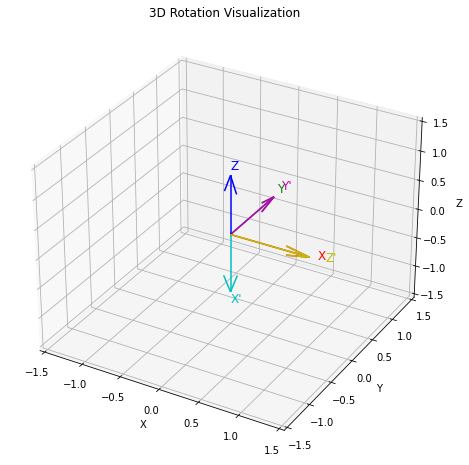

In [22]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot the coordinate axes
def plot_axes(ax, origin, vectors, colors, labels, label_offset=1.1):
    """Plot 3D coordinate axes."""
    for i in range(3):
        ax.quiver(origin[0], origin[1], origin[2],
                  vectors[i, 0], vectors[i, 1], vectors[i, 2],
                  color=colors[i], length=1.0, normalize=True)
        ax.text(*(origin + label_offset * vectors[i]), labels[i], color=colors[i], fontsize=12)

theta = np.pi / 2
phi = np.pi

R_z_phi = R.from_euler('z', phi)
R_y_theta = R.from_euler('y', theta)
R_z_neg_phi = R.from_euler('z', -phi)
R_combined = R_z_phi * R_y_theta * R_z_neg_phi
rotation_matrix = R_combined.as_matrix()

print("Rotation Matrix:")
print(rotation_matrix)

# Original coordinate system (identity matrix)
original_axes = np.eye(3)

# Rotated coordinate system
rotated_axes = rotation_matrix @ original_axes

# Set up the 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original coordinate axes
plot_axes(ax, origin=np.zeros(3), vectors=original_axes, 
          colors=['r', 'g', 'b'], labels=['X', 'Y', 'Z'])

# Plot the rotated coordinate axes
plot_axes(ax, origin=np.zeros(3), vectors=rotated_axes, 
          colors=['c', 'm', 'y'], labels=["X'", "Y'", "Z'"], label_offset=1.2)

# Set plot limits
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_zlim([-1.5, 1.5])

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Rotation Visualization')

# Show the plot
plt.show()

In [ ]:
import numpy as np
def cal_transformation_matrix(theta, phi, q=0, L=150):
    '''
    Inputs:
        L: the length of the segment
        theta, phi: angles
        q: the input of the linear actrator, in defult, equal to zero
    '''
    
    if theta == 0:
        rotation_matrix = np.eye(3)
        x = 0
        y = 0
        z = L
    else:
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        cos_phi = np.cos(phi)
        sin_phi = np.sin(phi)
        r = L/theta
        
        x = r * (1-cos_theta) * cos_phi
        y = r * (1-cos_theta) * sin_phi
        z = r * sin_theta + q
        
        R_z_phi = R.from_euler('z', phi)
        R_y_theta = R.from_euler('y', theta)
        R_z_neg_phi = R.from_euler('z', -phi)
        R_combined = R_z_phi * R_y_theta * R_z_neg_phi
        rotation_matrix = R_combined.as_matrix()

    T = np.array([
    [rotation_matrix[0, 0], rotation_matrix[0, 1], rotation_matrix[0, 2], x],
    [rotation_matrix[1, 0], rotation_matrix[1, 1], rotation_matrix[1, 2], y],
    [rotation_matrix[2, 0], rotation_matrix[2, 1], rotation_matrix[2, 2], z],
    [0, 0, 0, 1]])
    
    return T

In [32]:
def dual_segment_tip_pose(theta1, phi1, theta2, phi2, q1=0, q2=0, L1=150, L2=150):
    T1 = cal_transformation_matrix(theta1, phi1, q1, L1)        # transformation matrix of the first segment
    T2 = cal_transformation_matrix(theta2, phi2, q2, L2)
    T = T1 @ T2
    x = T[0,3]
    y = T[1,3]
    z = T[2,3]
     # Calculate Euler angles
    alpha = np.arctan2(T[2, 1], T[2, 2])
    beta = np.arctan2(-T[2, 0], np.linalg.norm([T[2, 1], T[2, 2]]))  # Use np.linalg.norm
    gamma = np.arctan2(T[1, 0], T[0, 0])
    
    return np.array([x, y, z, alpha, beta, gamma])

In [33]:
import numpy as np

pose = dual_segment_tip_pose(3.14/2, 3.14/2, 0, 0)
print(pose)

AttributeError: module 'numpy' has no attribute 'cos'

##### Using Jacobian method, which $P' = J\psi'$

$$
\begin{bmatrix}
x \\ y \\ z \\ \alpha \\ \beta \\ \gamma \\
\end{bmatrix}' = \begin{bmatrix}
\frac{\partial x}{\partial \theta_1} & \frac{\partial x}{\partial \phi_1} & \frac{\partial x}{\partial \theta_2} & \frac{\partial x}{\partial \phi_2} &  \\
\frac{\partial y}{\partial \theta_1} & \frac{\partial y}{\partial \phi_1} & 
\frac{\partial y}{\partial \theta_2} & \frac{\partial y}{\partial \phi_2}\\
\frac{\partial z}{\partial \theta_1} & \frac{\partial z}{\partial \phi_1} & 
\frac{\partial z}{\partial \theta_2} & \frac{\partial z}{\partial \phi_2}\\
\frac{\partial \alpha}{\partial \theta_1} & \frac{\partial \alpha}{\partial \phi_1} & \frac{\partial \alpha}{\partial \theta_2} & \frac{\partial \alpha}{\partial \phi_2} &  \\
\frac{\partial \beta}{\partial \theta_1} & \frac{\partial \beta}{\partial \phi_1} & 
\frac{\partial \beta}{\partial \theta_2} & \frac{\partial \beta}{\partial \phi_2}\\
\frac{\partial \gamma}{\partial \theta_1} & \frac{\partial \gamma}{\partial \phi_1} & 
\frac{\partial \gamma}{\partial \theta_2} & \frac{\partial \gamma}{\partial \phi_2}\\
\end{bmatrix} \begin{bmatrix}
\theta_1 \\ \phi_1 \\ \theta_2 \\ \phi_2 \\
\end{bmatrix}'
$$

with 

\begin{align*}
\frac{\partial x}{\partial \theta_1} &= \cos(\phi) \left( -\frac{L}{\theta^2} (1 - \cos(\theta)) + \frac{L}{\theta} \sin(\theta) \right) \\
\frac{\partial x}{\partial \phi} &= \frac{L}{\theta} (1 - \cos(\theta)) (-\sin(\phi)) \\
\frac{\partial y}{\partial \theta} &= \sin(\phi) \left( -\frac{L}{\theta^2} (1 - \cos(\theta)) + \frac{L}{\theta} \sin(\theta) \right) \\
\frac{\partial y}{\partial \phi} &= \frac{L}{\theta} (1 - \cos(\theta)) \cos(\phi) \\
\frac{\partial z}{\partial \theta} &= -\frac{L}{\theta^2} \sin(\theta) + \frac{L}{\theta} \cos(\theta) \\
\frac{\partial z}{\partial \phi} &= 0
\end{align*}

In [26]:
from sympy import Symbol, MatrixSymbol, Matrix

theta_1 = Symbol('theta_1')
phi_1 = Symbol('phi_1')
L_1 = Symbol("L_1")

f = L/theta * (1-cos(theta)) * cos(phi)

derivative_f = f.diff(theta)

derivative_f

ModuleNotFoundError: No module named 'sympy'

In [1]:
import sympy as sp

# Define the symbols
L_1 = sp.symbols('L_1')
phi_1 = sp.symbols('phi_1')
theta_1 = sp.symbols('theta_1')
L_2 = sp.symbols('L_2')
phi_2 = sp.symbols('phi_2')
theta_2 = sp.symbols('theta_2')

# Define P_1
P_1 = sp.Matrix([
    [L_1/theta_1 * (1 - sp.cos(theta_1)) * sp.cos(phi_1)],
    [L_1/theta_1 * (1 - sp.cos(theta_1)) * sp.sin(phi_1)],
    [L_1/theta_1 * sp.sin(theta_1)],
])

# Define the rotation matrix R_z(phi)
R_z_1 = sp.Matrix([
    [sp.cos(phi_1), -sp.sin(phi_1), 0],
    [sp.sin(phi_1), sp.cos(phi_1), 0],
    [0, 0, 1]
])

# Define the rotation matrix R_y(theta)
R_y_1 = sp.Matrix([
    [sp.cos(theta_1), 0, sp.sin(theta_1)],
    [0, 1, 0],
    [-sp.sin(theta_1), 0, sp.cos(theta_1)]
])

# Define the rotation matrix R_z(-phi)
R_z_neg_phi_1 = sp.Matrix([
    [sp.cos(phi_1), sp.sin(phi_1), 0],
    [-sp.sin(phi_1), sp.cos(phi_1), 0],
    [0, 0, 1]
])

# Compute the total rotation matrix R_1
R_1 = R_z_1 * R_y_1 * R_z_neg_phi_1

# Construct the transformation matrix T_1
T_1 = sp.Matrix([
    [R_1[0, 0], R_1[0, 1], R_1[0, 2], P_1[0]],
    [R_1[1, 0], R_1[1, 1], R_1[1, 2], P_1[1]],
    [R_1[2, 0], R_1[2, 1], R_1[2, 2], P_1[2]],
    [0, 0, 0, 1]
])

# Define P_2
P_2 = sp.Matrix([
    [L_2/theta_2 * (1 - sp.cos(theta_2)) * sp.cos(phi_2)],
    [L_2/theta_2 * (1 - sp.cos(theta_2)) * sp.sin(phi_2)],
    [L_2/theta_2 * sp.sin(theta_2)],
])

# Define the rotation matrix R_z(phi)
R_z_2 = sp.Matrix([
    [sp.cos(phi_2), -sp.sin(phi_2), 0],
    [sp.sin(phi_2), sp.cos(phi_2), 0],
    [0, 0, 1]
])

# Define the rotation matrix R_y(theta)
R_y_2 = sp.Matrix([
    [sp.cos(theta_2), 0, sp.sin(theta_2)],
    [0, 1, 0],
    [-sp.sin(theta_2), 0, sp.cos(theta_2)]
])

# Define the rotation matrix R_z(-phi)
R_z_neg_phi_2 = sp.Matrix([
    [sp.cos(phi_2), sp.sin(phi_2), 0],
    [-sp.sin(phi_2), sp.cos(phi_2), 0],
    [0, 0, 1]
])

# Compute the total rotation matrix R_2
R_2 = R_z_2 * R_y_2 * R_z_neg_phi_2

# Construct the transformation matrix T_2
T_2 = sp.Matrix([
    [R_2[0, 0], R_2[0, 1], R_2[0, 2], P_2[0]],
    [R_2[1, 0], R_2[1, 1], R_2[1, 2], P_2[1]],
    [R_2[2, 0], R_2[2, 1], R_2[2, 2], P_2[2]],
    [0, 0, 0, 1]
])

# Compute the combined transformation matrix T
T = T_2 * T_1

# Simplify each term of T and print
print("\nSimplified Transformation Matrix T:")
for i in range(T.shape[0]):  # Iterate over rows
    for j in range(T.shape[1]):  # Iterate over columns
        simplified_term = sp.simplify(T[i, j])  # Simplify the term
        print(f"T[{i}, {j}] = {simplified_term}")
        latex_output = sp.latex(simplified_term)
        print(f"T[{i}, {j}] LaTeX: {latex_output}")


Simplified Transformation Matrix T:
T[0, 0] = (sin(phi_1)**2 + cos(phi_1)**2*cos(theta_1))*(sin(phi_2)**2 + cos(phi_2)**2*cos(theta_2)) + (cos(theta_1) - 1)*(cos(theta_2) - 1)*sin(phi_1)*sin(phi_2)*cos(phi_1)*cos(phi_2) - sin(theta_1)*sin(theta_2)*cos(phi_1)*cos(phi_2)
T[0, 0] LaTeX: \left(\sin^{2}{\left(\phi_{1} \right)} + \cos^{2}{\left(\phi_{1} \right)} \cos{\left(\theta_{1} \right)}\right) \left(\sin^{2}{\left(\phi_{2} \right)} + \cos^{2}{\left(\phi_{2} \right)} \cos{\left(\theta_{2} \right)}\right) + \left(\cos{\left(\theta_{1} \right)} - 1\right) \left(\cos{\left(\theta_{2} \right)} - 1\right) \sin{\left(\phi_{1} \right)} \sin{\left(\phi_{2} \right)} \cos{\left(\phi_{1} \right)} \cos{\left(\phi_{2} \right)} - \sin{\left(\theta_{1} \right)} \sin{\left(\theta_{2} \right)} \cos{\left(\phi_{1} \right)} \cos{\left(\phi_{2} \right)}
T[0, 1] = (sin(phi_1)**2*cos(theta_1) + cos(phi_1)**2)*(cos(theta_2) - 1)*sin(phi_2)*cos(phi_2) + (sin(phi_2)**2 + cos(phi_2)**2*cos(theta_2))*(cos(theta_

$$
\begin{aligned}
    \frac{\partial x}{\partial \theta_{1}} 
    &= -\frac{L_1}{\theta_1^2}(1-cos(\phi_1))cos(\phi_1)(cos^2(\phi_2)cos(\theta_2)+sin^2(\phi_2)) \\
    & + \frac{L_1}{\theta_1}sin(\theta_1)cos(\phi_1)(cos^2(\phi_2)cos(\theta_2)+sin^2(\phi_2)) \\
    & - \frac{L_1}{\theta_1^2}(1-cos(\theta_1))sin(\phi_1)cos(\phi_2)sin(\phi_2)(cos(\theta_2)-1)\\
    & + \frac{L_1}{\theta_1}sin(\theta_1)sin(\phi_1)cos(\phi_2)sin(\phi_2)(cos(\theta_2)-1)\\
    & - \frac{L_1}{\theta_1^2}sin(\theta_1)sin(\theta_2)cos(\phi_2)+\frac{L_1}{\theta_1}cos(\theta_1)sin(\theta_2)cos(\phi_2)
\end{aligned}
$$


In [5]:
y = T[2,3]
y_theta_1 = y.diff(theta_1)
y_phi_1 = y.diff(phi_1)
y_theta_2 = y.diff(theta_2)
y_phi_2 = y.diff(phi_2)

latex_output_y_theta_1 = sp.latex(y_theta_1)
latex_output_y_phi_1 = sp.latex(y_phi_1)
latex_output_y_theta_2 = sp.latex(y_theta_2)
latex_output_y_phi_2 = sp.latex(y_phi_2)

# Print the formatted LaTeX
print(f"latex_output_y_theta_1: {latex_output_y_theta_1}")
print(f"latex_output_y_phi_1: {latex_output_y_phi_1}")
print(f"latex_output_y_theta_2: {latex_output_y_theta_2}")
print(f"latex_output_y_phi_2: {latex_output_y_phi_2}")

latex_output_y_theta_1: - \frac{L_{1} \sin{\left(\phi_{1} \right)} \sin{\left(\phi_{2} \right)} \sin{\left(\theta_{1} \right)} \sin{\left(\theta_{2} \right)}}{\theta_{1}} - \frac{L_{1} \sin{\left(\theta_{1} \right)} \sin{\left(\theta_{2} \right)} \cos{\left(\phi_{1} \right)} \cos{\left(\phi_{2} \right)}}{\theta_{1}} + \frac{L_{1} \cos{\left(\theta_{1} \right)} \cos{\left(\theta_{2} \right)}}{\theta_{1}} + \frac{L_{1} \cdot \left(1 - \cos{\left(\theta_{1} \right)}\right) \sin{\left(\phi_{1} \right)} \sin{\left(\phi_{2} \right)} \sin{\left(\theta_{2} \right)}}{\theta_{1}^{2}} + \frac{L_{1} \cdot \left(1 - \cos{\left(\theta_{1} \right)}\right) \sin{\left(\theta_{2} \right)} \cos{\left(\phi_{1} \right)} \cos{\left(\phi_{2} \right)}}{\theta_{1}^{2}} - \frac{L_{1} \sin{\left(\theta_{1} \right)} \cos{\left(\theta_{2} \right)}}{\theta_{1}^{2}}
latex_output_y_phi_1: \frac{L_{1} \cdot \left(1 - \cos{\left(\theta_{1} \right)}\right) \sin{\left(\phi_{1} \right)} \sin{\left(\theta_{2} \right)} \cos

In [17]:
alpha = sp.atan2(T[2,1], T[2,2])

# Calculate the partial derivatives
alpha_theta_1 = alpha.diff(theta_1)
alpha_phi_1 = alpha.diff(phi_1)
alpha_theta_2 = alpha.diff(theta_2)
alpha_phi_2 = alpha.diff(phi_2)

# Convert to LaTeX format
latex_output_alpha_theta_1 = sp.latex(alpha_theta_1)
latex_output_alpha_phi_1 = sp.latex(alpha_phi_1)
latex_output_alpha_theta_2 = sp.latex(alpha_theta_2)
latex_output_alpha_phi_2 = sp.latex(alpha_phi_2)

# Print the results
print(f"latex_output_alpha_theta_1: {latex_output_alpha_theta_1}")
print(f"latex_output_alpha_phi_1: {latex_output_alpha_phi_1}")
print(f"latex_output_alpha_theta_2: {latex_output_alpha_theta_2}")
print(f"latex_output_alpha_phi_2: {latex_output_alpha_phi_2}")

latex_output_alpha_theta_1: \frac{\left(\left(\sin^{2}{\left(\phi_{1} \right)} \cos{\left(\theta_{1} \right)} + \cos^{2}{\left(\phi_{1} \right)}\right) \sin{\left(\phi_{2} \right)} \sin{\left(\theta_{2} \right)} + \left(\sin{\left(\phi_{1} \right)} \cos{\left(\phi_{1} \right)} \cos{\left(\theta_{1} \right)} - \sin{\left(\phi_{1} \right)} \cos{\left(\phi_{1} \right)}\right) \sin{\left(\theta_{2} \right)} \cos{\left(\phi_{2} \right)} + \sin{\left(\phi_{1} \right)} \sin{\left(\theta_{1} \right)} \cos{\left(\theta_{2} \right)}\right) \left(- \sin{\left(\phi_{1} \right)} \sin{\left(\phi_{2} \right)} \sin{\left(\theta_{2} \right)} \cos{\left(\theta_{1} \right)} - \sin{\left(\theta_{1} \right)} \cos{\left(\theta_{2} \right)} - \sin{\left(\theta_{2} \right)} \cos{\left(\phi_{1} \right)} \cos{\left(\phi_{2} \right)} \cos{\left(\theta_{1} \right)}\right)}{\left(- \left(\sin^{2}{\left(\phi_{1} \right)} \cos{\left(\theta_{1} \right)} + \cos^{2}{\left(\phi_{1} \right)}\right) \sin{\left(\phi_{2} \r

In [18]:
beta = sp.atan2(-T[2,0], sp.sqrt(T[2,1]**2+T[2,2]**2))

beta_theta_1 = beta.diff(theta_1)
beta_phi_1 = beta.diff(phi_1)
beta_theta_2 = beta.diff(theta_2)
beta_phi_2 = beta.diff(phi_2)

latex_output_beta_theta_1 = sp.latex(beta_theta_1)
latex_output_beta_phi_1 = sp.latex(beta_phi_1)
latex_output_beta_theta_2 = sp.latex(beta_theta_2)
latex_output_beta_phi_2 = sp.latex(beta_phi_2)

print(f"latex_output_beta_theta_1: {latex_output_beta_theta_1}")
print(f"latex_output_beta_phi_1: {latex_output_beta_phi_1}")
print(f"latex_output_beta_theta_2: {latex_output_beta_theta_2}")
print(f"latex_output_beta_phi_2: {latex_output_beta_phi_2}")



latex_output_beta_theta_1: \frac{\left(\frac{\left(- \left(\sin^{2}{\left(\phi_{1} \right)} \cos{\left(\theta_{1} \right)} + \cos^{2}{\left(\phi_{1} \right)}\right) \sin{\left(\phi_{2} \right)} \sin{\left(\theta_{2} \right)} - \left(\sin{\left(\phi_{1} \right)} \cos{\left(\phi_{1} \right)} \cos{\left(\theta_{1} \right)} - \sin{\left(\phi_{1} \right)} \cos{\left(\phi_{1} \right)}\right) \sin{\left(\theta_{2} \right)} \cos{\left(\phi_{2} \right)} - \sin{\left(\phi_{1} \right)} \sin{\left(\theta_{1} \right)} \cos{\left(\theta_{2} \right)}\right) \left(2 \sin^{2}{\left(\phi_{1} \right)} \sin{\left(\phi_{2} \right)} \sin{\left(\theta_{1} \right)} \sin{\left(\theta_{2} \right)} + 2 \sin{\left(\phi_{1} \right)} \sin{\left(\theta_{1} \right)} \sin{\left(\theta_{2} \right)} \cos{\left(\phi_{1} \right)} \cos{\left(\phi_{2} \right)} - 2 \sin{\left(\phi_{1} \right)} \cos{\left(\theta_{1} \right)} \cos{\left(\theta_{2} \right)}\right)}{2} + \frac{\left(- \sin{\left(\phi_{1} \right)} \sin{\left(\phi

In [19]:
gamma = sp.atan2(T[1,0], T[0,0])

gamma_theta_1 = gamma.diff(theta_1)
gamma_phi_1 = gamma.diff(phi_1)
gamma_theta_2 = gamma.diff(theta_2)
gamma_phi_2 = gamma.diff(phi_2)

latex_output_gamma_theta_1 = sp.latex(gamma_theta_1)
latex_output_gamma_phi_1 = sp.latex(gamma_phi_1)
latex_output_gamma_theta_2 = sp.latex(gamma_theta_2)
latex_output_gamma_phi_2 = sp.latex(gamma_phi_2)


print(f"latex_output_gamma_theta_1: {latex_output_gamma_theta_1}")
print(f"latex_output_gamma_phi_1: {latex_output_gamma_phi_1}")
print(f"latex_output_gamma_theta_2: {latex_output_gamma_theta_2}")
print(f"latex_output_gamma_phi_2: {latex_output_gamma_phi_2}")

latex_output_gamma_theta_1: \frac{\left(- \left(\sin^{2}{\left(\phi_{2} \right)} \cos{\left(\theta_{2} \right)} + \cos^{2}{\left(\phi_{2} \right)}\right) \left(\sin{\left(\phi_{1} \right)} \cos{\left(\phi_{1} \right)} \cos{\left(\theta_{1} \right)} - \sin{\left(\phi_{1} \right)} \cos{\left(\phi_{1} \right)}\right) - \left(\sin{\left(\phi_{2} \right)} \cos{\left(\phi_{2} \right)} \cos{\left(\theta_{2} \right)} - \sin{\left(\phi_{2} \right)} \cos{\left(\phi_{2} \right)}\right) \left(\sin^{2}{\left(\phi_{1} \right)} + \cos^{2}{\left(\phi_{1} \right)} \cos{\left(\theta_{1} \right)}\right) + \sin{\left(\phi_{2} \right)} \sin{\left(\theta_{1} \right)} \sin{\left(\theta_{2} \right)} \cos{\left(\phi_{1} \right)}\right) \left(- \left(\sin{\left(\phi_{2} \right)} \cos{\left(\phi_{2} \right)} \cos{\left(\theta_{2} \right)} - \sin{\left(\phi_{2} \right)} \cos{\left(\phi_{2} \right)}\right) \sin{\left(\phi_{1} \right)} \sin{\left(\theta_{1} \right)} \cos{\left(\phi_{1} \right)} - \left(\sin^{2}{\le